<a href="https://colab.research.google.com/github/mstale007/Transpilation_of_Full_Adder_Quantum_Circuit/blob/main/Optimizing_Quantum_Circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Qiskit

In [ ]:
!pip3 install qiskit

In [20]:
from qiskit import *
import matplotlib

# Let's build an adder circuit

*   A full adder adds two input bits say X and Y plus a Carry and gives sum and generated carry as output
*   To implement a Full Adder on a quantum computer we will need 5 qubits:

      1.   Two for inputs bits X and Y
      2.   One for input Carry (Cin)
      3.   One for output Sum
      4.   One for output Carry (Cout)

For calculating sum we will simply use CNOT gate 

And for finding Cout we will use a  Controlled-Controlled-Not gate or Toffoli gate like this:




In [21]:
qr=QuantumRegister(5,'q')
cr=ClassicalRegister(2,'c')

In [22]:
circuit=QuantumCircuit(qr,cr)

The input to this circuit will be X as 1 and Y as 0 

In [23]:
#Sum
circuit.x(q[0])
circuit.cx(q[0],q[3])
circuit.cx(q[1],q[3])
circuit.cx(q[2],q[3])
#Carry
circuit.ccx(q[0],q[1],q[4])
circuit.ccx(q[0],q[2],q[4])
circuit.ccx(q[1],q[2],q[4])

#Masuring output sum and carry
circuit.measure(q[3],c[0])
circuit.measure(q[4],c[1])

In [25]:
circuit.draw()

┌───┐                                    
q_0: ┤ X ├──■──────────────■────■─────────────
     └───┘  │              │    │             
q_1: ───────┼────■─────────■────┼───────■─────
            │    │         │    │       │     
q_2: ───────┼────┼────■────┼────■───────■─────
          ┌─┴─┐┌─┴─┐┌─┴─┐  │    │  ┌─┐  │     
q_3: ─────┤ X ├┤ X ├┤ X ├──┼────┼──┤M├──┼─────
          └───┘└───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┴─┐┌─┐
q_4: ────────────────────┤ X ├┤ X ├─╫─┤ X ├┤M├
                         └───┘└───┘ ║ └───┘└╥┘
c: 2/═══════════════════════════════╩═══════╩═
                                    0       1

Now let's execute this on a simulator and get the output for only one shot

In [26]:
simulator=Aer.get_backend('qasm_simulator')
result = execute(circuit,simulator,shots=1).result()

In [27]:
from qiskit.tools.visualization import plot_histogram

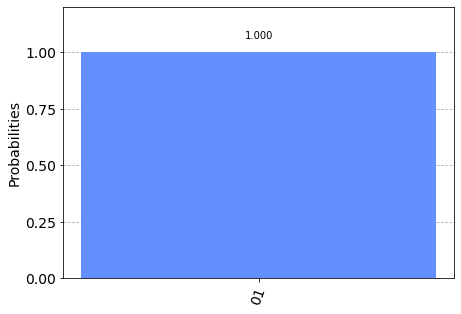

In [28]:
plot_histogram(result.get_counts(circuit))

As expected we get sum as 1 and carry as 0 for inputs 0 and 1

# Optimizing the Circuit

*   Mathematically it is easy to design and gates as unitary operators and non- gate operators like measurment to a qubits. 
*   But todays noisy quantum systems have many limitaitions and are prone to errors hence they can just support few fundamental operation 
*   Due to which, any quantum circuits that is built on top of these quantum systems must be expressed using only these basis gates

##### Now let's try and break this circuit in it's corresponding basis gates using `decompose()` function

In [42]:
circuit_basis=circuit.decompose()
circuit_basis.draw()

┌─────────────┐                                                         »
q_0: ┤ U3(pi,0,pi) ├──■─────────────────────────────■─────────────────────■──»
     └─────────────┘  │                             │             ┌───┐   │  »
q_1: ─────────────────┼────■─────────■──────────────┼─────────■───┤ T ├───┼──»
                      │    │         │              │         │   └───┘   │  »
q_2: ─────────────────┼────┼────■────┼──────────────┼─────────┼───────────┼──»
                    ┌─┴─┐┌─┴─┐┌─┴─┐  │         ┌─┐  │         │           │  »
q_3: ───────────────┤ X ├┤ X ├┤ X ├──┼─────────┤M├──┼─────────┼───────────┼──»
          ┌───┐     └───┘└───┘└───┘┌─┴─┐┌─────┐└╥┘┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐»
q_4: ─────┤ H ├────────────────────┤ X ├┤ TDG ├─╫─┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├»
          └───┘                    └───┘└─────┘ ║ └───┘└───┘└───┘└─────┘└───┘»
c: 2/═══════════════════════════════════════════╩════════════════════════════»
                                                0                            »
«           ┌───┐                                                   ┌───┐      »
«q_0: ──■───┤ T ├───■────────────────■─────────────────────■────■───┤ T ├───■──»
«     ┌─┴─┐┌┴───┴┐┌─┴─┐              │                     │    │   └───┘   │  »
«q_1: ┤ X ├┤ TDG ├┤ X ├──────────────┼─────────────────────┼────┼───────────┼──»
«     └───┘└─────┘└───┘              │             ┌───┐   │  ┌─┴─┐┌─────┐┌─┴─┐»
«q_2: ───────────────────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ TDG ├┤ X ├»
«                        │           │         │   └───┘   │  └───┘└─────┘└───┘»
«q_3: ───────────────────┼───────────┼─────────┼───────────┼───────────────────»
«     ┌───┐ ┌───┐ ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐ ┌───┐ ┌───┐»
«q_4: ┤ T ├─┤ H ├─┤ H ├┤ X ├┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├─┤ H ├─┤ H ├»
«     └───┘ └───┘ └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘ └───┘»
«c: 2/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                             
«q_0: ────────────────────────────────────────────────────────
«                                                  ┌───┐      
«q_1: ──────────────■─────────────────────■────■───┤ T ├───■──
«                   │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
«q_2: ──■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ TDG ├┤ X ├
«       │           │         │   └───┘   │  └───┘└─────┘└───┘
«q_3: ──┼───────────┼─────────┼───────────┼───────────────────
«     ┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐ ┌───┐  ┌─┐ 
«q_4: ┤ X ├┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├─┤ H ├──┤M├─
«     └───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘  └╥┘ 
«c: 2/═════════════════════════════════════════════════════╩══
«                                                          1

And as we can see the number of gates and the **depth** of the circuit **increases drasctically** when we break this full adder circuit in basis gates

    Depth:  The circuit depth is the length of the longest path from the input to the output, moving forward in time along qubit wires.

In [68]:
print('Initially: ', circuit.depth(), '\nAfter Decompositon: ', circuit_basis.depth())

Initially:  7 
After Decompositon:  33


#### Now let's optimize this Full adder ciruit using the `Transpiler` module

The transpilation process of Qiskit follows 6 `passes` and rewrites entire given input circuit either to match the toplogy to the physical quantum device and/or to optimize the circuit 

There are 4 pre-built transpilation pipelines available in Qiskit:
1. `level_0_pass_manager`
2. `level_1_pass_manager`
3. `level_2_pass_manager`
4. `level_3_pass_manager`

Now Let's see how they will work for our case


###Level 0 optimization

In [58]:
transpiled_circuit=transpile(circuit,simulator,optimization_level=0)

In [59]:
transpiled_circuit.draw()

┌───┐                                    
q_0: ┤ X ├──■──────────────■────■─────────────
     └───┘  │              │    │             
q_1: ───────┼────■─────────■────┼───────■─────
            │    │         │    │       │     
q_2: ───────┼────┼────■────┼────■───────■─────
          ┌─┴─┐┌─┴─┐┌─┴─┐  │    │  ┌─┐  │     
q_3: ─────┤ X ├┤ X ├┤ X ├──┼────┼──┤M├──┼─────
          └───┘└───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┴─┐┌─┐
q_4: ────────────────────┤ X ├┤ X ├─╫─┤ X ├┤M├
                         └───┘└───┘ ║ └───┘└╥┘
c: 2/═══════════════════════════════╩═══════╩═
                                    0       1

In [60]:
print('Depth:', transpiled_circuit.depth())
print('Gate counts:', transpiled_circuit.count_ops())

Depth: 7
Gate counts: OrderedDict([('cx', 3), ('ccx', 3), ('measure', 2), ('x', 1)])


**Result** : No explicit optimization other than mapping to backend.

###Level 1 optimization

Optimizations by collapsing adjacent gates.

In [61]:
transpiled_circuit=transpile(circuit,simulator,optimization_level=1)
transpiled_circuit.draw()

┌───┐                                    
q_0: ┤ X ├──■──────────────■────■─────────────
     └───┘  │              │    │             
q_1: ───────┼────■─────────■────┼───────■─────
            │    │         │    │       │     
q_2: ───────┼────┼────■────┼────■───────■─────
          ┌─┴─┐┌─┴─┐┌─┴─┐  │    │  ┌─┐  │     
q_3: ─────┤ X ├┤ X ├┤ X ├──┼────┼──┤M├──┼─────
          └───┘└───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┴─┐┌─┐
q_4: ────────────────────┤ X ├┤ X ├─╫─┤ X ├┤M├
                         └───┘└───┘ ║ └───┘└╥┘
c: 2/═══════════════════════════════╩═══════╩═
                                    0       1

In [62]:
print('Depth:', transpiled_circuit.depth())
print('Gate counts:', transpiled_circuit.count_ops())

Depth: 7
Gate counts: OrderedDict([('cx', 3), ('ccx', 3), ('measure', 2), ('x', 1)])


**Result:** No optimization in terms of number of gates and depth

### Level 2 optimization

Optimization by initial layout selection and gate cancellation using commutativity rules.


In [63]:
transpiled_circuit=transpile(circuit,simulator,optimization_level=2)
transpiled_circuit.draw()

┌───┐                                    
q_0: ┤ X ├──■──────────────■────■─────────────
     └───┘  │              │    │             
q_1: ───────┼────■─────────■────┼───────■─────
            │    │         │    │       │     
q_2: ───────┼────┼────■────┼────■───────■─────
          ┌─┴─┐┌─┴─┐┌─┴─┐  │    │  ┌─┐  │     
q_3: ─────┤ X ├┤ X ├┤ X ├──┼────┼──┤M├──┼─────
          └───┘└───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┴─┐┌─┐
q_4: ────────────────────┤ X ├┤ X ├─╫─┤ X ├┤M├
                         └───┘└───┘ ║ └───┘└╥┘
c: 2/═══════════════════════════════╩═══════╩═
                                    0       1

In [64]:
print('Depth:', transpiled_circuit.depth())
print('Gate counts:', transpiled_circuit.count_ops())

Depth: 7
Gate counts: OrderedDict([('cx', 3), ('ccx', 3), ('measure', 2), ('x', 1)])


**Result:** No optimizations on Level 2

###Level 3 optimization
Optimization by noise adaptive qubit mapping and gate cancellation using commutativity rules and unitary synthesis.

In [65]:
transpiled_circuit=transpile(circuit,simulator,optimization_level=3)
transpiled_circuit.draw()

┌───┐                                                              »
q_0: ┤ X ├──■─────────────────────────────■─────────────────────■────■──»
     └───┘  │                             │             ┌───┐   │  ┌─┴─┐»
q_1: ───────┼────■─────────■──────────────┼─────────■───┤ T ├───┼──┤ X ├»
            │    │         │              │         │   └───┘   │  └───┘»
q_2: ───────┼────┼────■────┼──────────────┼─────────┼───────────┼───────»
          ┌─┴─┐┌─┴─┐┌─┴─┐  │         ┌─┐  │         │           │       »
q_3: ─────┤ X ├┤ X ├┤ X ├──┼─────────┤M├──┼─────────┼───────────┼───────»
     ┌───┐└───┘└───┘└───┘┌─┴─┐┌─────┐└╥┘┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐»
q_4: ┤ H ├───────────────┤ X ├┤ TDG ├─╫─┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├»
     └───┘               └───┘└─────┘ ║ └───┘└───┘└───┘└─────┘└───┘└───┘»
c: 2/═════════════════════════════════╩═════════════════════════════════»
                                      0                                 »
«     ┌──────────┐                                                        »
«q_0: ┤ U1(pi/2) ├───■─────■─────────────────────■────■───────────■───────»
«     └─┬─────┬──┘ ┌─┴─┐   │                     │    │           │       »
«q_1: ──┤ TDG ├────┤ X ├───┼─────────────────────┼────┼───────────┼───────»
«       └─────┘    └───┘   │             ┌───┐   │  ┌─┴─┐┌─────┐┌─┴─┐     »
«q_2: ─────■───────────────┼─────────■───┤ T ├───┼──┤ X ├┤ TDG ├┤ X ├──■──»
«          │               │         │   └───┘   │  └───┘└─────┘└───┘  │  »
«q_3: ─────┼───────────────┼─────────┼───────────┼─────────────────────┼──»
«        ┌─┴─┐    ┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐            ┌─┴─┐»
«q_4: ───┤ X ├────┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├────────────┤ X ├»
«        └───┘    └─────┘└───┘└───┘└───┘└─────┘└───┘└───┘            └───┘»
«c: 2/════════════════════════════════════════════════════════════════════»
«                                                                         »
«                                                        
«q_0: ───────────────────────────────────────────────────
«                                             ┌───┐      
«q_1: ─────────■─────────────────────■────■───┤ T ├───■──
«              │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
«q_2: ─────────┼─────────■───┤ T ├───┼──┤ X ├┤ TDG ├┤ X ├
«              │         │   └───┘   │  └───┘└─────┘└───┘
«q_3: ─────────┼─────────┼───────────┼───────────────────
«     ┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐ ┌───┐  ┌─┐ 
«q_4: ┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├─┤ H ├──┤M├─
«     └─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘  └╥┘ 
«c: 2/════════════════════════════════════════════════╩══
«                                                     1

In [66]:
print('Depth:', transpiled_circuit.depth())
print('Gate counts:', transpiled_circuit.count_ops())

Depth: 31
Gate counts: OrderedDict([('cx', 21), ('t', 10), ('tdg', 9), ('h', 2), ('measure', 2), ('x', 1), ('u1', 1)])


In [77]:
IBMQ.save_account('API-TOKEN')

In [78]:
IBMQ.load_account()

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-10-13 18:47:55,191: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [87]:
provider = IBMQ.get_provider(hub='ibm-q')
device=provider.get_backend('ibmq_valencia')
transpiled_circuit=transpile(circuit,device,optimization_level=0)
job =device.run(assemble(transpiled_circuit,shots=2048))

In [88]:
from qiskit.tools.monitor import job_monitor

In [89]:
job_monitor(job)

Job Status: job has successfully run


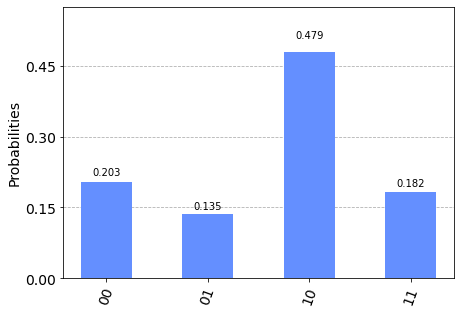

In [90]:
result=job.result().get_counts()
plot_histogram(result)

In [101]:
provider = IBMQ.get_provider(hub='ibm-q')
device=provider.get_backend('ibmq_valencia')
transpiled_circuit=transpile(circuit,device,optimization_level=3)
job =device.run(assemble(transpiled_circuit,shots=6000))

job_monitor(job)

Job Status: job has successfully run


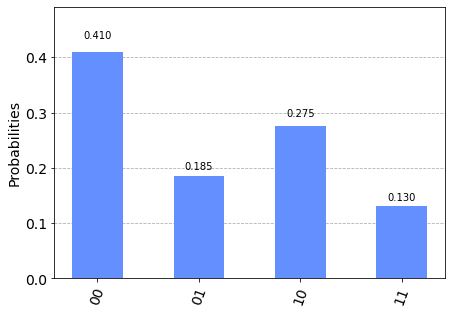

In [102]:
result=job.result().get_counts()
plot_histogram(result)

As we can see when the Full adder circuit is optimized to Level 3 the Depth of the circuit increases and that makes it more prone to error and noise.

The Results may vary every time the circuit is executed